In [ ]:
!pip install scikit-learn tensorflow


In [ ]:
!pip install scikit-learn scipy joblib matplotlib tensorflow --quiet


Loaded test shape: (25889, 124)
Numeric columns retained: 122
Feature shape: (25889, 402)
Prepared X: (25889, 402)
PCA dims: 100
Present weighted models: ['pca_rec_err', 'gmm_nll', 'knn_dist_k3', 'knn_dist_k5', 'knn_dist_k10', 'mahal_sq', 'if_cont_0.01', 'if_cont_0.03', 'if_cont_0.05', 'if_cont_0.08', 'ocsvm_nu_0.01', 'ocsvm_nu_0.03', 'ocsvm_nu_0.05', 'lof', 'ae_wide', 'ae_deep']
Flagged 776 anomalies (contamination=0.03)
Saved predictions_task5.csv
Top 10 anomalies by score:
             id  anomaly_score  is_anomaly
15454  ANS15455       1.000000           1
10546  ANS10547       0.999882           1
6272   ANS06273       0.998733           1
12426  ANS12427       0.995554           1
17526  ANS17527       0.994246           1
12160  ANS12161       0.992542           1
7483   ANS07484       0.991808           1
14897  ANS14898       0.991287           1
19237  ANS19238       0.987922           1
16247  ANS16248       0.984455           1


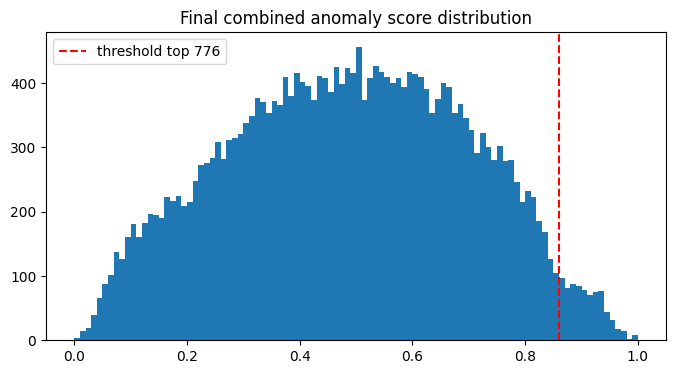

Saved artifacts to artifacts


In [ ]:
import os, sys
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# sklearn & utilities
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import LedoitWolf
from scipy.stats import rankdata
import joblib

# plotting optional
try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except:
    HAS_MPL = False

# TensorFlow (optional for autoencoders)
HAS_TF = True
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, regularizers, callbacks
    tf.get_logger().setLevel('ERROR')
except Exception:
    HAS_TF = False

# ------------------------
# CONFIG (tuneable)
# ------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if HAS_TF:
    try: tf.random.set_seed(RANDOM_SEED)
    except: pass

TEST_PATH = "/content/test.csv"   # prior fraction of anomalies (tune with domain knowledge)
AE_EPOCHS = 60
AE_BATCH = 256
PCA_FRACTION = 0.25               # fraction of dims for PCA used in boundary/density models
ARTIFACT_DIR = "artifacts"

# Multi-level settings
IF_CONTAM_LIST = [0.01, 0.03, 0.05, 0.08]     # multi-contamination IF ensemble
OCSVM_NU_LIST = [0.01, 0.03, 0.05]           # multi-nu OCSVM ensemble
K_NEIGHBORS = [3,5,10]                       # k for kNN-distance scores

# ------------------------
# Load test.csv (local or upload)
# ------------------------
def load_test(path=TEST_PATH):
    if os.path.exists(path):
        return pd.read_csv(path)
    # try Colab upload fallback
    try:
        from google.colab import files
        uploaded = files.upload()
        for fn in uploaded.keys():
            if fn.lower().endswith(".csv"):
                return pd.read_csv(fn)
        raise FileNotFoundError("No CSV uploaded")
    except Exception as e:
        raise RuntimeError("Could not load test.csv. Put at /mnt/data/test.csv or upload in Colab.") from e

df_raw = load_test()
print("Loaded test shape:", df_raw.shape)

# ------------------------
# ID handling & drop non-numeric columns
# ------------------------
id_col = None
for cand in ["id","ID","Id","account_id","accountId","player_id","playerId","user_id","userId"]:
    if cand in df_raw.columns:
        id_col = cand
        break

non_numeric_cols = df_raw.select_dtypes(exclude=[np.number]).columns.tolist()
if id_col is None and len(non_numeric_cols) >= 1:
    # prefer likely id-like strings
    for c in non_numeric_cols:
        if ("player" in c.lower()) or ("account" in c.lower()) or c.lower().startswith("p"):
            id_col = c
            break
    if id_col is None:
        id_col = non_numeric_cols[0]

ids_original = df_raw[id_col].astype(str).values if (id_col and id_col in df_raw.columns) else None
drop_cols = [c for c in non_numeric_cols if c != id_col]
if drop_cols:
    df = df_raw.drop(columns=drop_cols)
else:
    df = df_raw.copy()

print("Numeric columns retained:", df.select_dtypes(include=[np.number]).shape[1])

# ------------------------
# Feature engineering (safe, non-fragmented)
# ------------------------
def add_prefix_features(df_numeric):
    prefixes = sorted({c.rsplit("_",1)[0] for c in df_numeric.columns if "_" in c})
    parts = []
    idx = df_numeric.index
    for p in prefixes:
        cols = sorted([c for c in df_numeric.columns if c.startswith(p + "_")])
        if len(cols) == 0:
            continue
        tmp = df_numeric[cols].apply(pd.to_numeric, errors='coerce')
        # column-wise fill
        for c in tmp.columns:
            if tmp[c].isnull().all():
                tmp[c] = 0.0
        tmp = tmp.fillna(tmp.median())
        arr = tmp.values.astype(float)
        feat = pd.DataFrame(index=idx)
        feat[f"{p}_mean"] = arr.mean(axis=1)
        feat[f"{p}_std"]  = arr.std(axis=1) + 1e-9
        feat[f"{p}_min"]  = arr.min(axis=1)
        feat[f"{p}_max"]  = arr.max(axis=1)
        feat[f"{p}_range"] = feat[f"{p}_max"] - feat[f"{p}_min"]
        # slope
        if arr.shape[1] >= 1:
            t = np.arange(1,arr.shape[1]+1)
            t_mean = t.mean()
            denom = ((t - t_mean)**2).sum()
            if denom == 0:
                feat[f"{p}_slope"] = 0.0
            else:
                numer = ((arr - arr.mean(axis=1, keepdims=True)) * (t - t_mean)).sum(axis=1)
                feat[f"{p}_slope"] = numer / (denom + 1e-12)
        else:
            feat[f"{p}_slope"] = 0.0
        # pct change and diffs
        if arr.shape[1] >= 2:
            feat[f"{p}_pct_change"] = (arr[:, -1] - arr[:, 0]) / (np.abs(arr[:, 0]) + 1e-6)
            for i in range(arr.shape[1]-1):
                feat[f"{p}_diff_{i+1}_{i+2}"] = arr[:, i+1] - arr[:, i]
        else:
            feat[f"{p}_pct_change"] = 0.0
        feat[f"{p}_cv"] = feat[f"{p}_std"] / (np.abs(feat[f"{p}_mean"]) + 1e-9)
        per_row_std = np.nanstd(arr, axis=1, keepdims=True)
        threshold_mask = arr > (arr.mean(axis=1, keepdims=True) + 2 * per_row_std)
        feat[f"{p}_outlier_ratio"] = np.nanmean(threshold_mask, axis=1)
        parts.append(feat)
    return pd.concat(parts, axis=1) if parts else pd.DataFrame(index=df_numeric.index)

df_numeric = df.copy()
engineered = add_prefix_features(df_numeric)
# keep single-period numeric columns (no underscore) as originals
original_keep = [c for c in df_numeric.columns if "_" not in c and c != id_col]
orig_part = df_numeric[original_keep].fillna(0) if original_keep else pd.DataFrame(index=df_numeric.index)
df_model = pd.concat([orig_part, engineered], axis=1).fillna(0)
print("Feature shape:", df_model.shape)

# ------------------------
# Preprocess: impute & scale
# ------------------------
imp = SimpleImputer(strategy="median"); scaler = RobustScaler()
X = imp.fit_transform(df_model.values)
X = scaler.fit_transform(X)
n_samples, n_features = X.shape
print("Prepared X:", X.shape)

# ------------------------
# PCA for stability (boundary/density)
# ------------------------
if isinstance(PCA_FRACTION, float) and PCA_FRACTION < 1.0:
    pca_n = max(5, int(n_features * PCA_FRACTION))
else:
    pca_n = min(n_features, int(PCA_FRACTION))
pca_n = min(pca_n, n_features-1) if n_features > 1 else 1
pca = PCA(n_components=pca_n, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)
print("PCA dims:", pca_n)

# ------------------------
# Score collectors
# ------------------------
scores = {}   # name -> 1D array (higher => more anomalous)

# 1) PCA reconstruction error
try:
    pca_recon = pca.inverse_transform(X_pca)
    pca_rec_err = np.mean((X - pca_recon)**2, axis=1)
    scores['pca_rec_err'] = pca_rec_err
except Exception:
    scores['pca_rec_err'] = np.zeros(n_samples)

# 2) GMM negative log-likelihood (density)
try:
    gmm = GaussianMixture(n_components=min(8, max(2, pca_n)), random_state=RANDOM_SEED)
    gmm.fit(X_pca)
    gmm_nll = -gmm.score_samples(X_pca)   # higher = rarer = more anomalous
    scores['gmm_nll'] = gmm_nll
except Exception:
    scores['gmm_nll'] = np.zeros(n_samples)

# 3) kNN distances (k-th neighbor) for multiple k
for k in K_NEIGHBORS:
    try:
        nbrs = NearestNeighbors(n_neighbors=min(n_samples-1, k+1), n_jobs=-1).fit(X)
        dists, idx = nbrs.kneighbors(X)
        # distance to k-th neighbor (skip self at index 0)
        kth = dists[:, -1]
        scores[f'knn_dist_k{k}'] = kth
    except Exception:
        scores[f'knn_dist_k{k}'] = np.zeros(n_samples)

# 4) Mahalanobis distance (regularized empirical covariance)
try:
    # Use Ledoit-Wolf shrinkage for stability when dims high
    cov_est = LedoitWolf().fit(X)
    mahal = cov_est.mahalanobis(X)  # returns squared Mahalanobis distance
    scores['mahal_sq'] = mahal
except Exception:
    try:
        cov_est = EmpiricalCovariance().fit(X)
        mahal = cov_est.mahalanobis(X)
        scores['mahal_sq'] = mahal
    except Exception:
        scores['mahal_sq'] = np.zeros(n_samples)

# 5) Multiple IsolationForest (multi-contamination)
for cont in IF_CONTAM_LIST:
    try:
        iso = IsolationForest(n_estimators=256, contamination=cont, random_state=RANDOM_SEED, n_jobs=-1)
        iso.fit(X)
        scr = -iso.score_samples(X)
        scores[f'if_cont_{cont}'] = scr
    except Exception:
        scores[f'if_cont_{cont}'] = np.zeros(n_samples)

# 6) One-Class SVM (multiple nu) on PCA
for nu in OCSVM_NU_LIST:
    try:
        ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)
        ocsvm.fit(X_pca)
        scr = -ocsvm.score_samples(X_pca)
        scores[f'ocsvm_nu_{nu}'] = scr
    except Exception:
        scores[f'ocsvm_nu_{nu}'] = np.zeros(n_samples)

# 7) Local Outlier Factor (novelty True) on PCA
try:
    lof = LocalOutlierFactor(n_neighbors=35, contamination=CONTAMINATION, novelty=True)
    lof.fit(X_pca)
    scr = -lof.score_samples(X_pca)
    scores['lof'] = scr
except Exception:
    scores['lof'] = np.zeros(n_samples)

# 8) Autoencoders (if TensorFlow available): ensemble of 2 architectures
if HAS_TF:
    def build_ae(input_dim, hidden=[128,64,32]):
        inp = layers.Input(shape=(input_dim,))
        x = inp
        for h in hidden[:-1]:
            x = layers.Dense(h, activation='relu')(x)
        encoded = layers.Dense(hidden[-1], activation='relu')(x)
        x = encoded
        for h in reversed(hidden[:-1]):
            x = layers.Dense(h, activation='relu')(x)
        out = layers.Dense(input_dim, activation='linear')(x)
        model = models.Model(inp, out)
        model.compile(optimizer='adam', loss='mse')
        return model
    try:
        ae1 = build_ae(n_features, hidden=[128,64,32])
        es = callbacks.EarlyStopping(monitor='loss', patience=6, restore_best_weights=True, verbose=0)
        ae1.fit(X, X, epochs=AE_EPOCHS, batch_size=AE_BATCH, shuffle=True, callbacks=[es], verbose=0)
        rec1 = ae1.predict(X, batch_size=1024, verbose=0); ae1_err = np.mean((X - rec1)**2, axis=1)
        scores['ae_wide'] = ae1_err
    except Exception as e:
        scores['ae_wide'] = np.zeros(n_samples)
    try:
        ae2 = build_ae(n_features, hidden=[64,32,16])
        ae2.fit(X, X, epochs=AE_EPOCHS, batch_size=AE_BATCH, shuffle=True, callbacks=[es], verbose=0)
        rec2 = ae2.predict(X, batch_size=1024, verbose=0); ae2_err = np.mean((X - rec2)**2, axis=1)
        scores['ae_deep'] = ae2_err
    except Exception as e:
        scores['ae_deep'] = np.zeros(n_samples)
else:
    scores['ae_wide'] = np.zeros(n_samples)
    scores['ae_deep'] = np.zeros(n_samples)

# ------------------------
# Normalize & rank each score to [0,1] where 1 = most anomalous
# ------------------------
ranked = {}
for k,v in scores.items():
    arr = np.nan_to_num(v, nan=np.nanmedian(v))
    # larger raw => more anomalous -> rank highest
    r = rankdata(-arr, method='average')  # bigger arr -> smaller rank number
    ranked[k] = (r.max() - r) / (r.max() - r.min() + 1e-9)

# ------------------------
# Weighted aggregation of ranks
# Choose weights to favor recall (F3) — give more weight to IF, AE, knn/gmm/mahal
# ------------------------
base_weights = {
    'if_cont_0.01': 0.12, 'if_cont_0.03': 0.12, 'if_cont_0.05': 0.10, 'if_cont_0.08': 0.08,
    'ae_wide': 0.12, 'ae_deep': 0.08,
    'knn_dist_k3': 0.06, 'knn_dist_k5': 0.06, 'knn_dist_k10': 0.04,
    'gmm_nll': 0.08, 'mahal_sq': 0.06, 'pca_rec_err': 0.04,
    'ocsvm_nu_0.01': 0.03, 'ocsvm_nu_0.03': 0.03, 'ocsvm_nu_0.05': 0.02,
    'lof': 0.03
}

# build final combined score (only include present ranked keys)
final_score = np.zeros(n_samples)
present = []
for k in ranked.keys():
    w = base_weights.get(k, 0.0)
    if w == 0.0:
        # small default weight to include extra models lightly
        w = 0.0
    final_score += w * ranked[k]
    if w > 0: present.append(k)

# normalize final score to [0,1]
if final_score.max() - final_score.min() > 0:
    final_score = (final_score - final_score.min()) / (final_score.max() - final_score.min())
else:
    final_score = np.zeros_like(final_score)

print("Present weighted models:", present)

# ------------------------
# meta-ensemble step: average different thresholds
# ------------------------
k_flag = max(1, int(n_samples * CONTAMINATION))
sorted_idx = np.argsort(-final_score)
threshold = float(final_score[sorted_idx[k_flag-1]])
is_anomaly = (final_score >= threshold).astype(int)
print(f"Flagged {int(is_anomaly.sum())} anomalies (contamination={CONTAMINATION})")

# ------------------------
# Output predictions
# ------------------------
if ids_original is not None:
    out_ids = ids_original
else:
    out_ids = [f"ANS{str(i+1).zfill(5)}" for i in range(n_samples)]

out = pd.DataFrame({
    "id": out_ids,
    "anomaly_score": final_score,
    "is_anomaly": is_anomaly
})
out.to_csv("predictions_task5.csv", index=False)
print("Saved predictions_task5.csv")

# Diagnostics: top 10
print("Top 10 anomalies by score:")
print(out.sort_values("anomaly_score", ascending=False).head(10))

# Plot
if HAS_MPL:
    try:
        plt.figure(figsize=(8,4)); plt.hist(final_score, bins=100)
        plt.axvline(threshold, color='red', linestyle='--', label=f"threshold top {k_flag}")
        plt.title("Final combined anomaly score distribution"); plt.legend(); plt.show()
    except:
        pass

# Save artifacts
try:
    os.makedirs(ARTIFACT_DIR, exist_ok=True)
    joblib.dump({"imputer": imp, "scaler": scaler, "pca": pca, "feat_cols": df_model.columns.tolist()}, os.path.join(ARTIFACT_DIR, "preproc.joblib"))
    print("Saved artifacts to", ARTIFACT_DIR)
    # save autoencoders if present
    if HAS_TF:
        try:
            ae1.save(os.path.join(ARTIFACT_DIR, "ae_wide.keras"), include_optimizer=False)
            ae2.save(os.path.join(ARTIFACT_DIR, "ae_deep.keras"), include_optimizer=False)
        except:
            pass
except Exception as e:
    print("Artifacts save failed:", e)

